# Plant Disease Classification - Training and Inferencing

This notebook explores training and inferencing of Resnet50 baseline model for Plant Disease Classificaton. Here, we use machine learning techniques to improve the performance of the baseline model.

### Importing Libraries needed

First, we import all  the necessary libraries for data analysis as seen below:

In [1]:
# importing the fastai libraries for computer vision
from fastcore.all import *
from fastai.vision.all import *
from fastai.metrics import accuracy, F1Score, Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
#imoorting supplementary libraries
import warnings
warnings.filterwarnings('ignore') 

### Setting the Data path object

We then set up the path object from our downloaded dataset directory as seen below:

In [3]:
data_dir = '/home/roach/plantdisease/data'

In [4]:
path = Path(data_dir)

### Putting Data in Dataloaders

In this section we load our data into Dataloaders which is a class that allows data to be loaded for training. Additionally, it simplifies processes like batch loading, data augmentation, data resizing, splitting data into training and validation, among others.

In [5]:
# Define a DataBlock for image classification using fastai
plt_dis = DataBlock(
    # Specify the types of blocks (ImageBlock for images, CategoryBlock for categories/labels)
    blocks=(ImageBlock, CategoryBlock),
    
    # Function to get the items (in this case, image files)
    get_items=get_image_files,
    
    # Splitter function to split data into training and validation sets randomly (with a seed for reproducibility)
    splitter=RandomSplitter(seed=42),
    
    # Function to get the labels (in this case, parent folder labels)
    get_y=parent_label,
    
    # Transformations to apply to each item (resizing images to 460x460)
    item_tfms=Resize(460),
    
    # Batch-level transformations (data augmentations like resizing and random flips)
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)


In [6]:
# Create DataLoaders using the plt_dis DataBlock for image classification on the dataset located at 'path'.
dls = plt_dis.dataloaders(path)

### Training Resnet50 baseline model

In [7]:
learn = vision_learner(dls, resnet50, metrics=[
    accuracy, 
    F1Score(average='macro'), 
    Precision(average='macro'), 
    Recall(average='macro')
])

learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.574701,0.348485,0.884175,0.757595,0.794035,0.767007,08:13


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.224717,0.161869,0.946513,0.886904,0.901291,0.895470,08:47
1,0.144953,0.117428,0.960928,0.919415,0.929032,0.917562,08:47


In [8]:
interp = ClassificationInterpretation.from_learner(learn)

In [9]:
interp.most_confused(min_val=5)

[('Soybean__diabrotica_speciosa', 'Soybean__caterpillar', 37),
 ('Rice__leaf_blast', 'Rice__healthy', 29),
 ('Cassava__bacterial_blight', 'Cassava__healthy', 27),
 ('Soybean__caterpillar', 'Soybean__diabrotica_speciosa', 22),
 ('Cassava__brown_streak_disease', 'Cassava__healthy', 20),
 ('Corn__gray_leaf_spot', 'Corn__northern_leaf_blight', 17),
 ('Rice__leaf_blast', 'Rice__brown_spot', 17),
 ('Cassava__healthy', 'Cassava__bacterial_blight', 16),
 ('Coffee__red_spider_mite', 'Coffee__rust', 15),
 ('Rice__brown_spot', 'Rice__healthy', 15),
 ('Soybean__caterpillar', 'Soybean__healthy', 15),
 ('Cassava__green_mottle', 'Cassava__healthy', 14),
 ('Tea__anthracnose', 'Tea__bird_eye_spot', 14),
 ('Corn__northern_leaf_blight', 'Corn__gray_leaf_spot', 13),
 ('Rice__brown_spot', 'Rice__leaf_blast', 13),
 ('Cassava__brown_streak_disease', 'Cassava__bacterial_blight', 12),
 ('Cassava__mosaic_disease', 'Cassava__green_mottle', 11),
 ('Coffee__rust', 'Coffee__red_spider_mite', 10),
 ('Cassava__bacter

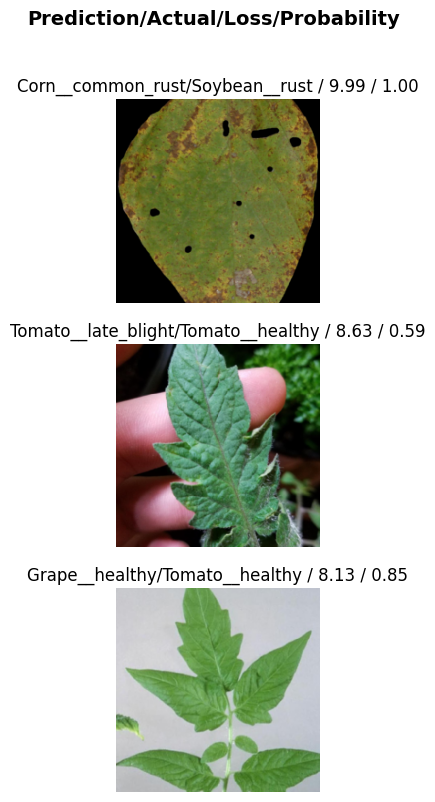

In [10]:
interp.plot_top_losses(3, nrows=3)

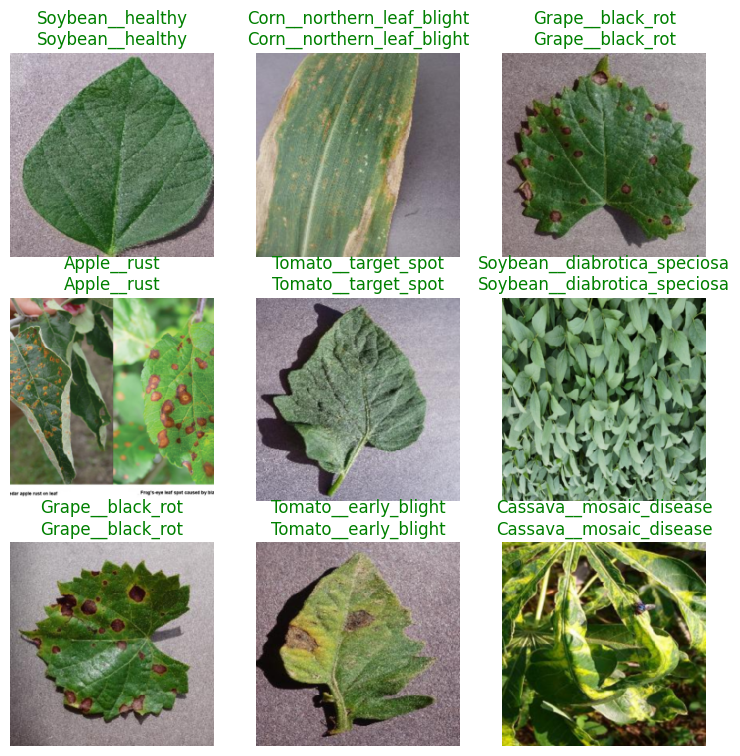

In [11]:
learn.show_results()

### Improving our model

In [12]:
import gc
import torch

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    
clear_memory()

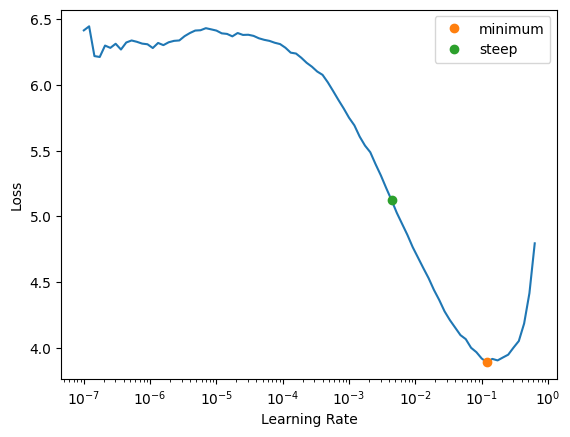

In [13]:
learn = vision_learner(dls, resnet50, metrics=[
    accuracy, 
    F1Score(average='macro'), 
    Precision(average='macro'), 
    Recall(average='macro')
])


lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [14]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest point: 4.37e-03


In [15]:
learn = vision_learner(dls, resnet50, metrics=[
    accuracy, 
    F1Score(average='macro'), 
    Precision(average='macro'), 
    Recall(average='macro')
])

learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(14, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.452780,0.285923,0.906303,0.778835,0.815344,0.795869,08:36
1,0.256261,0.158934,0.945186,0.888901,0.907622,0.883269,08:39
2,0.161003,0.128974,0.956439,0.911185,0.921083,0.911045,08:31


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.148750,0.126956,0.957135,0.913308,0.922334,0.912866,09:04
1,0.151149,0.122372,0.959031,0.917929,0.925714,0.916815,09:00
2,0.134089,0.117409,0.960738,0.920198,0.926897,0.919663,09:01
3,0.125724,0.111617,0.962319,0.928884,0.932503,0.928804,08:48
4,0.123095,0.111430,0.962951,0.922013,0.930881,0.919748,08:49
5,0.109013,0.106509,0.964974,0.925757,0.930823,0.926583,08:50
6,0.092016,0.103690,0.965796,0.933339,0.938882,0.932584,08:49
7,0.101058,0.100995,0.967187,0.934850,0.939523,0.934337,08:51
8,0.091781,0.098617,0.967756,0.934018,0.938290,0.933636,08:49
9,0.089879,0.098270,0.967819,0.932977,0.937181,0.931678,08:51


In [16]:
interp = ClassificationInterpretation.from_learner(learn)

In [17]:
interp.most_confused(min_val=5)

[('Soybean__caterpillar', 'Soybean__diabrotica_speciosa', 26),
 ('Cassava__bacterial_blight', 'Cassava__healthy', 25),
 ('Soybean__diabrotica_speciosa', 'Soybean__caterpillar', 25),
 ('Rice__leaf_blast', 'Rice__healthy', 24),
 ('Cassava__brown_streak_disease', 'Cassava__healthy', 18),
 ('Cassava__healthy', 'Cassava__bacterial_blight', 18),
 ('Cassava__green_mottle', 'Cassava__healthy', 16),
 ('Corn__gray_leaf_spot', 'Corn__northern_leaf_blight', 14),
 ('Rice__brown_spot', 'Rice__leaf_blast', 14),
 ('Rice__brown_spot', 'Rice__healthy', 13),
 ('Coffee__red_spider_mite', 'Coffee__rust', 10),
 ('Rice__healthy', 'Rice__leaf_blast', 10),
 ('Rice__leaf_blast', 'Rice__brown_spot', 9),
 ('Soybean__caterpillar', 'Soybean__healthy', 9),
 ('Cassava__bacterial_blight', 'Cassava__brown_streak_disease', 8),
 ('Cassava__brown_streak_disease', 'Cassava__bacterial_blight', 8),
 ('Cassava__mosaic_disease', 'Cassava__healthy', 8),
 ('Coffee__rust', 'Coffee__red_spider_mite', 8),
 ('Cassava__brown_streak_d

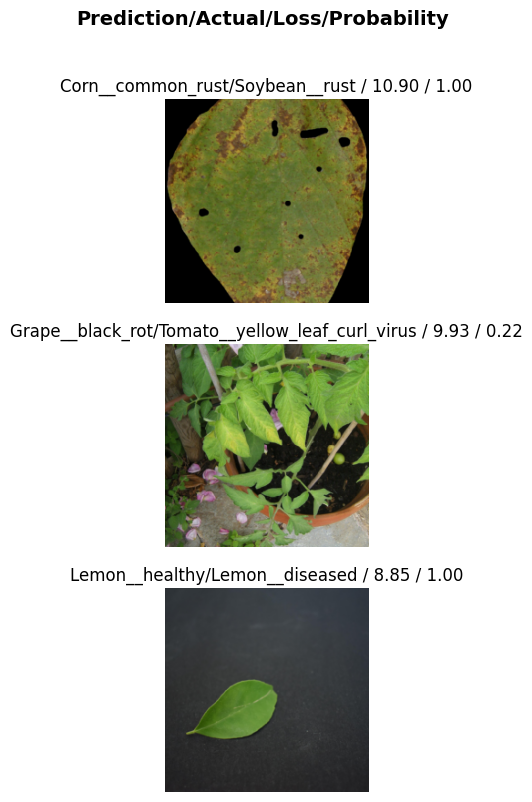

In [18]:
interp.plot_top_losses(3, nrows=3)

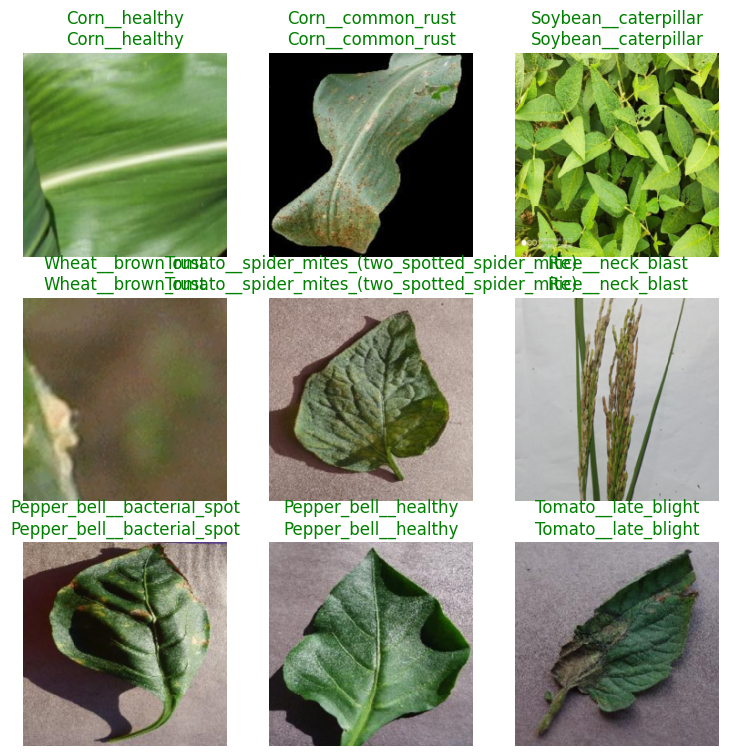

In [19]:
learn.show_results()

In [29]:
learn.export()